# Lesson 15.2 学习率调度在PyTorch中的实现方法

&emsp;&emsp;学习率调度作为模型优化的重要方法，也集成在了PyTorch的`optim`模块中。
- from torch.optim import lr_scheduler
- 学习率随着迭代的次数增加而不断改变

In [1]:
from torch.optim import lr_scheduler

## 一、优化器与状态字典（state_dict）

模型优化器是求解损失函数的函数，其中包含了模型训练的诸多关键信息，包括模型参数、模型学习率等，同时在进行模型训练时，我们也是通过优化器调整模型参数、归零模型梯度。

而在学习率调度过程中，由于我们需要动态调整学习率，而学习率又是通过传入优化器进而影响模型训练的，因此在利用PyTorch进行学习率调度的时候，核心需要考虑的问题是**如何让优化器内的学习率随着迭代次数增加而不断变化**。      

&emsp;&emsp;为做到这一点，首先我们需要补充关于优化器状态字典内容。

- `torch.optim.SGD(模型.parameters(),lr=学习率)` 创建优化器
- `优化器.state_dict()`方法查看优化器状态字典
  - 返回优化器的状态'state'
  - 以及优化器的参数'param_groups'
    - params表示训练参数个数（其中一个矩阵算作一个参数）
- `optimizer.state_dict()['param_groups'][0]['lr']` 提取优化器参数中lr的取值
  

In [2]:
# 设置随机数种子
torch.manual_seed(420)  

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w=[2, -1, 3, 1, 2], bias=False, deg=2)

# 进行数据集切分与加载
train_loader, test_loader = split_loader(features, labels, batch_size=50)

In [3]:
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
tanh_model1 = net_class2(act_fun= torch.tanh, in_features=5, BN_model='pre')

In [4]:
# 创建优化器
optimizer = torch.optim.SGD(tanh_model1.parameters(),lr=0.01)

In [5]:
# 查看优化器状态
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.01,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

In [6]:
optimizer.state_dict()['param_groups']

[{'lr': 0.01,
  'momentum': 0,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False,
  'maximize': False,
  'foreach': None,
  'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]

In [7]:
optimizer.state_dict()['param_groups'][0]['lr']

0.01

In [9]:
# params表示训练参数个数，可以通过如下方式进行简单验证
list(tanh_model1.parameters())

[Parameter containing:
 tensor([[ 0.2365, -0.1118, -0.3801,  0.0275,  0.4168],
         [-0.1995, -0.1456,  0.3497, -0.0622, -0.1708],
         [-0.0901,  0.0164, -0.3643, -0.1278,  0.4336],
         [-0.0959,  0.4073, -0.1746, -0.1799, -0.1333]], requires_grad=True),
 Parameter containing:
 tensor([-0.3999, -0.2694,  0.2703, -0.3355], requires_grad=True),
 Parameter containing:
 tensor([1., 1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0.], requires_grad=True),
 Parameter containing:
 tensor([[ 0.1708,  0.4704, -0.0635,  0.2187],
         [ 0.2336, -0.3569, -0.1928, -0.1566],
         [ 0.4825, -0.4463,  0.3027,  0.4696],
         [ 0.3953,  0.2131,  0.2226, -0.0267]], requires_grad=True),
 Parameter containing:
 tensor([ 0.2516,  0.4558, -0.1608,  0.4831], requires_grad=True),
 Parameter containing:
 tensor([1., 1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0.], requires_grad=True),
 Parameter containing:
 tensor([[ 0.07

In [10]:
# 验证带训练参数个数
len(list(tanh_model1.parameters()))

10

In [11]:
tanh_model2 = net_class3(act_fun= torch.tanh, in_features=5, BN_model='pre')

In [12]:
optimizer1 = torch.optim.SGD(tanh_model2.parameters(), lr=0.05)
optimizer1.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.05,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}]}

In [13]:
len(list(tanh_model2.parameters()))

14

---

### <center> 模型本地保存与读取方法 

&emsp;&emsp;借助`state_dict()`方法，我们可以实现模型或优化器的本地保存于读取。此处以模型为例，优化器的本地保存相关操作类似。      
&emsp;&emsp;对于模型而言，其实也有`state_dict()`方法。通过该方法的调用，可以查看模型全部参数信息。

- `torch.save(tanh_model1.state_dict(), 'tanh1.pt')`来将该参数保存至本地
  - 一个参数是需要保存的模型参数，而第二个参数则是保存到本地的文件名
  - 一般来说可以令其后缀为`.pt`或`.pth`
  - 而当我们需要读取保存的参数结果时，可以使用load_state_dict方法
- `torch.load('tanh1.pt')` 导入储存的本地数据
- `tanh_model1.load_state_dict(torch.load('tanh1.pt'))` 用本地数据还原参数

In [14]:
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
tanh_model1 = net_class2(act_fun= torch.tanh, in_features=5, BN_model='pre')

In [15]:
tanh_model1.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.2365, -0.1118, -0.3801,  0.0275,  0.4168],
                      [-0.1995, -0.1456,  0.3497, -0.0622, -0.1708],
                      [-0.0901,  0.0164, -0.3643, -0.1278,  0.4336],
                      [-0.0959,  0.4073, -0.1746, -0.1799, -0.1333]])),
             ('linear1.bias', tensor([-0.3999, -0.2694,  0.2703, -0.3355])),
             ('normalize1.weight', tensor([1., 1., 1., 1.])),
             ('normalize1.bias', tensor([0., 0., 0., 0.])),
             ('normalize1.running_mean', tensor([0., 0., 0., 0.])),
             ('normalize1.running_var', tensor([1., 1., 1., 1.])),
             ('normalize1.num_batches_tracked', tensor(0)),
             ('linear2.weight',
              tensor([[ 0.1708,  0.4704, -0.0635,  0.2187],
                      [ 0.2336, -0.3569, -0.1928, -0.1566],
                      [ 0.4825, -0.4463,  0.3027,  0.4696],
                      [ 0.3953,  0.2131,  0.2226, -0.0267]])),
             ('linea

首先，我们可以将该存有模型全部参数信息的字典对象赋给某个变量。

In [16]:
t1 = tanh_model1.state_dict()
t1

OrderedDict([('linear1.weight',
              tensor([[ 0.2365, -0.1118, -0.3801,  0.0275,  0.4168],
                      [-0.1995, -0.1456,  0.3497, -0.0622, -0.1708],
                      [-0.0901,  0.0164, -0.3643, -0.1278,  0.4336],
                      [-0.0959,  0.4073, -0.1746, -0.1799, -0.1333]])),
             ('linear1.bias', tensor([-0.3999, -0.2694,  0.2703, -0.3355])),
             ('normalize1.weight', tensor([1., 1., 1., 1.])),
             ('normalize1.bias', tensor([0., 0., 0., 0.])),
             ('normalize1.running_mean', tensor([0., 0., 0., 0.])),
             ('normalize1.running_var', tensor([1., 1., 1., 1.])),
             ('normalize1.num_batches_tracked', tensor(0)),
             ('linear2.weight',
              tensor([[ 0.1708,  0.4704, -0.0635,  0.2187],
                      [ 0.2336, -0.3569, -0.1928, -0.1566],
                      [ 0.4825, -0.4463,  0.3027,  0.4696],
                      [ 0.3953,  0.2131,  0.2226, -0.0267]])),
             ('linea

其次，我们也可以通过`torch.save`来将该参数保存至本地。

In [17]:
torch.save(tanh_model1.state_dict(), 'tanh1.pt')

- 模型参数训练

当我们进行模型训练时，实际上就是借助损失函数和反向传播机制进行梯度求解，然后利用优化器根据梯度值去更新各线性层参数

In [18]:
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(tanh_model1.parameters(), lr=0.05)

In [19]:
for X, y in train_loader:
    yhat = tanh_model1.forward(X)
    loss = criterion(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [22]:
# 训练完一轮之后，我们可以查看模型状态：
tanh_model1.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.1837, -0.2990, -0.3235,  0.0331,  0.4835],
                      [-0.2971, -0.1304,  0.2700,  0.0287, -0.3070],
                      [ 0.1294,  0.1729, -0.2994, -0.2714,  0.4283],
                      [-0.1686,  0.4945, -0.1437, -0.1727, -0.0758]])),
             ('linear1.bias', tensor([-0.3999, -0.2694,  0.2703, -0.3355])),
             ('normalize1.weight', tensor([1.0653, 0.9840, 1.0446, 1.0984])),
             ('normalize1.bias', tensor([ 0.2773, -0.0783, -0.2868,  0.0459])),
             ('normalize1.running_mean',
              tensor([-0.2842, -0.2179,  0.2145, -0.2602])),
             ('normalize1.running_var',
              tensor([0.5320, 0.4225, 0.5139, 0.4278])),
             ('normalize1.num_batches_tracked', tensor(14)),
             ('linear2.weight',
              tensor([[ 0.2558,  0.5226, -0.1346,  0.3224],
                      [ 0.1675, -0.0388, -0.4682, -0.3733],
                      [ 0.4295, -0.3640,  

In [23]:
# 我们发现模型的参数已经发生了变化。当然，此时t1也随之发生了变化
t1

# t1是储存在本地的数据

OrderedDict([('linear1.weight',
              tensor([[ 0.1837, -0.2990, -0.3235,  0.0331,  0.4835],
                      [-0.2971, -0.1304,  0.2700,  0.0287, -0.3070],
                      [ 0.1294,  0.1729, -0.2994, -0.2714,  0.4283],
                      [-0.1686,  0.4945, -0.1437, -0.1727, -0.0758]])),
             ('linear1.bias', tensor([-0.3999, -0.2694,  0.2703, -0.3355])),
             ('normalize1.weight', tensor([1.0653, 0.9840, 1.0446, 1.0984])),
             ('normalize1.bias', tensor([ 0.2773, -0.0783, -0.2868,  0.0459])),
             ('normalize1.running_mean',
              tensor([-0.2842, -0.2179,  0.2145, -0.2602])),
             ('normalize1.running_var',
              tensor([0.5320, 0.4225, 0.5139, 0.4278])),
             ('normalize1.num_batches_tracked', tensor(14)),
             ('linear2.weight',
              tensor([[ 0.2558,  0.5226, -0.1346,  0.3224],
                      [ 0.1675, -0.0388, -0.4682, -0.3733],
                      [ 0.4295, -0.3640,  

此时，如果我们想还原tanh_model1中原始参数，我们只能考虑通过使用`load_state_dict`方法，将本次保存的原模型参数替换当前的tanh_model1中参数，具体方法如下：

In [24]:
torch.load('tanh1.pt')

OrderedDict([('linear1.weight',
              tensor([[ 0.2365, -0.1118, -0.3801,  0.0275,  0.4168],
                      [-0.1995, -0.1456,  0.3497, -0.0622, -0.1708],
                      [-0.0901,  0.0164, -0.3643, -0.1278,  0.4336],
                      [-0.0959,  0.4073, -0.1746, -0.1799, -0.1333]])),
             ('linear1.bias', tensor([-0.3999, -0.2694,  0.2703, -0.3355])),
             ('normalize1.weight', tensor([1., 1., 1., 1.])),
             ('normalize1.bias', tensor([0., 0., 0., 0.])),
             ('normalize1.running_mean', tensor([0., 0., 0., 0.])),
             ('normalize1.running_var', tensor([1., 1., 1., 1.])),
             ('normalize1.num_batches_tracked', tensor(0)),
             ('linear2.weight',
              tensor([[ 0.1708,  0.4704, -0.0635,  0.2187],
                      [ 0.2336, -0.3569, -0.1928, -0.1566],
                      [ 0.4825, -0.4463,  0.3027,  0.4696],
                      [ 0.3953,  0.2131,  0.2226, -0.0267]])),
             ('linea

In [25]:
tanh_model1.load_state_dict(torch.load('tanh1.pt'))

<All keys matched successfully>

In [26]:
tanh_model1.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.2365, -0.1118, -0.3801,  0.0275,  0.4168],
                      [-0.1995, -0.1456,  0.3497, -0.0622, -0.1708],
                      [-0.0901,  0.0164, -0.3643, -0.1278,  0.4336],
                      [-0.0959,  0.4073, -0.1746, -0.1799, -0.1333]])),
             ('linear1.bias', tensor([-0.3999, -0.2694,  0.2703, -0.3355])),
             ('normalize1.weight', tensor([1., 1., 1., 1.])),
             ('normalize1.bias', tensor([0., 0., 0., 0.])),
             ('normalize1.running_mean', tensor([0., 0., 0., 0.])),
             ('normalize1.running_var', tensor([1., 1., 1., 1.])),
             ('normalize1.num_batches_tracked', tensor(0)),
             ('linear2.weight',
              tensor([[ 0.1708,  0.4704, -0.0635,  0.2187],
                      [ 0.2336, -0.3569, -0.1928, -0.1566],
                      [ 0.4825, -0.4463,  0.3027,  0.4696],
                      [ 0.3953,  0.2131,  0.2226, -0.0267]])),
             ('linea

至此，我们就完成了模型训练与保存的基本过程。当然，除了模型可以按照上述方法保存外，优化器也可以类似进行本地存储。

## 二、LambdaLR基本使用方法

&emsp;&emsp;让优化器动态调整学习率的类，也被我们称为学习率调度器类，该类实例化的对象也被称为学习率调度器。在所有的学习率调度器中，LambdaLR类是实现学习率调度最简单灵活、同时也是最通用的一种方法。

- `scheduler = lr_scheduler.LambdaLR(optimizer,lr_lambda) ` 创建学习率调度器
- optimizer.state_dict()

&emsp;&emsp;使用LambdaLR来完成学习率调度，首先需要准备一个lambda匿名函数，例如：

In [31]:
lr_lambda = lambda epoch:0.5 ** epoch

# 此处我们通过lambda创建了一个匿名函数。
# 该函数需要输入一个参数，一般来说我们会将该参数视作模型迭代次数。
# 输出结果就是0.5的epoch次方。

In [32]:
# 第一轮迭代时
lr_lambda(0)

1.0

- 准备好一个匿名函数
- 实例化一个LambdaLR学习率调度器
- 创建一个对应的优化器

In [34]:
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
tanh_model1 = net_class2(act_fun= torch.tanh, in_features=5, BN_model='pre')

In [36]:
# 创建优化器
optimizer = torch.optim.SGD(tanh_model1.parameters(),lr=0.05)

# 查看优化器信息
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.05,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

In [38]:
# 创建学习率调度器
scheduler = lr_scheduler.LambdaLR(optimizer,lr_lambda)

# 参数1： 与之关联的优化器，参数2：labda函数
# LambdaLR学习率调度器的创建必须要输入一个lambda函数和与之关联的优化器。
# 一旦优化器创建完成，我们即可继续观察优化器optimizer的状态。

In [39]:
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.05,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'initial_lr': 0.05,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

&emsp;&emsp;此时优化器的参数簇中多了'initial_lr'元素。该元素代表初始学习率，也就是我们在实例化优化器时输入的学习率。而优化器中的lr，则仍然表示下一次迭代时的学习率。

对于LambdaLR学习调度来说，优化器中的lr伴随模型迭代相应调整的方法如下：
$$lr = lr\_lambda(epoch) * initial\_lr$$

&emsp;&emsp;并且，第一次实例化LambdaLR时epoch取值为0时，因此此时优化器的lr计算结果如下：$$lr_0 = 0.5^0 * 0.05 = 0.05$$

而在后续计算过程中，每当我们调用一次scheduler.step()，epoch数值就会+1。我们可以进行下述实验，即当一轮训练完成时，我们可通过scheduler.step()来更新下一轮迭代时的学习率。

In [40]:
for X, y in train_loader:
    yhat = tanh_model1.forward(X)
    loss = criterion(yhat,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# 遍历所有数据后，更新到scheduler中的lr
scheduler.step()


In [42]:
optimizer.state_dict()

# 只更新了一次： 0.05^1 *0.05 = 0.025
# lr 编程了0.025

{'state': {0: {'momentum_buffer': None},
  1: {'momentum_buffer': None},
  2: {'momentum_buffer': None},
  3: {'momentum_buffer': None},
  4: {'momentum_buffer': None},
  5: {'momentum_buffer': None},
  6: {'momentum_buffer': None},
  7: {'momentum_buffer': None},
  8: {'momentum_buffer': None},
  9: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.025,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'initial_lr': 0.05,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

&emsp;&emsp;至此，我们也就知道了scheduler.step()的真实作用——令匿名函数的自变量+1，然后令匿名函数的输出结果与initial_lr相乘，并把计算结果传给优化器，作为下一次优化器计算时的学习率。

&emsp;&emsp;当然，我们也能简单的重复optimizer.step()与scheduler.step()，即可一次次完成计算新学习率、并将新学习率传输给优化器的过程。

In [43]:
#————————————————————手动更新（第二次更新）———————————————————

optimizer.zero_grad()  # 梯度清零
optimizer.step()
scheduler.step()

In [45]:
lr_lambda = lambda epoch : 0.5 ** epoch
lr_lambda(2) * 0.05

# 0.5^2 *initial_lr(0.05)

0.0125

In [46]:
optimizer.state_dict()

{'state': {0: {'momentum_buffer': None},
  1: {'momentum_buffer': None},
  2: {'momentum_buffer': None},
  3: {'momentum_buffer': None},
  4: {'momentum_buffer': None},
  5: {'momentum_buffer': None},
  6: {'momentum_buffer': None},
  7: {'momentum_buffer': None},
  8: {'momentum_buffer': None},
  9: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.0125,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'initial_lr': 0.05,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

In [47]:
ss = scheduler.state_dict()
ss

# '_step_count': 3 : 从1开始计数,step了两次

{'base_lrs': [0.05],
 'last_epoch': 2,
 '_step_count': 3,
 'verbose': False,
 '_get_lr_called_within_step': False,
 '_last_lr': [0.0125],
 'lr_lambdas': [None]}

> 此处需要注意，PyTorch中要求先进行优化器的step，再进行学习率调度的step，此处需要注意先后顺序。   
> 另外，上述过程之所以提前将优化器内保存的模型参数清零，也是为了防止上述实验过程最终导致模型参数被修改（梯度为0时模型无法修改参数）

当然，每一轮epoch都让模型学习率衰减50%其实是非常激进的

我们可以通过绘制图像观察学习率衰减情况。

In [48]:
# 创建优化器
optimizer = torch.optim.SGD(tanh_model1.parameters(),lr=0.05)

In [49]:
# 创建学习率调度器
scheduler = lr_scheduler.LambdaLR(optimizer,lr_lambda)

In [51]:
optimizer.state_dict()['param_groups']

[{'lr': 0.05,
  'momentum': 0,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False,
  'maximize': False,
  'foreach': None,
  'initial_lr': 0.05,
  'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]

In [50]:
optimizer.state_dict()['param_groups'][0]['lr']

0.05

In [53]:
# 更新10次optimizer中的学习率

lr_l = [0.05]

for i in range(10):
    optimizer.step()
    scheduler.step()
    # 把下轮循环需要的lr对象拿出来
    lr = optimizer.state_dict()['param_groups'][0]['lr']
    lr_l.append(lr)

Text(0.5, 0, 'epoch')

Text(0, 0.5, 'Learning rate')

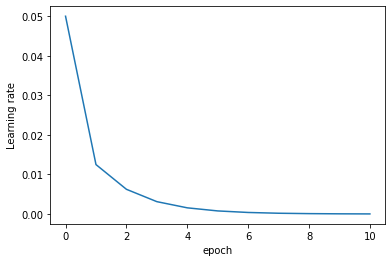

In [54]:
plt.plot(lr_l)
plt.xlabel('epoch')
plt.ylabel('Learning rate')

接下来，我们放缓学习率衰减速率，进行学习率调度建模实验。

## 三、LambdaLR学习率调度实验

### 1.前期准备与匿名函数定义

&emsp;&emsp;在实验开始前，我们需要将之前定义的fit_rec函数再次进行改写，新函数需要包含学习率调度相关方法。

In [56]:
def fit_rec_sc(net, 
               criterion, 
               optimizer, 
               train_data,
               test_data,
               scheduler,
               epochs = 3, 
               cla = False, 
               eva = mse_cal):
    """加入学习率调度后的模型训练函数（记录每一次遍历后模型评估指标）
    
    :param net：待训练的模型 
    :param criterion: 损失函数
    :param optimizer：优化算法
    :param train_data：训练数据
    :param test_data: 测试数据 
    :param scheduler: 学习率调度器
    :param epochs: 遍历数据次数
    :param cla: 是否是分类问题
    :param eva: 模型评估方法
    :return：模型评估结果
    """
    train_l = []
    test_l = []

    for epoch  in range(epochs):
        net.train()
        for X, y in train_data:
            if cla == True:
                y = y.flatten().long()          # 如果是分类问题，需要对y进行整数转化
            yhat = net.forward(X)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # 根据全部数据，更新学习率上的数值
        scheduler.step()
        # 模型进入测试模式
        net.eval()
        train_l.append(eva(train_data, net).detach())
        test_l.append(eva(test_data, net).detach())
    return train_l, test_l

In [60]:
#———————————————定义一个衰减速度更加缓慢的学习率调度器——————————————

lr_lambda = lambda epoch: 0.95 ** epoch

# 每次只衰减5%

In [61]:
# 第一轮迭代时
lr_lambda(0)

1.0

In [62]:
# 第二轮迭代时
lr_lambda(1)

0.95

In [63]:
lr_lambda(100)

# 0.95^100 暂未乘以初始lr

0.0059205292203339975

In [64]:
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
tanh_model1 = net_class2(act_fun=torch.tanh, in_features=5, BN_model='pre')

In [65]:
# 创建优化器
optimizer = torch.optim.SGD(tanh_model1.parameters(), lr=0.05)

In [66]:
# 创建学习率调度器
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)

### 3.模型训练与结果比较

In [67]:
# 进行模型训练
train_l, test_l = fit_rec_sc(net = tanh_model1, 
                             criterion = nn.MSELoss(), 
                             optimizer = optimizer, 
                             train_data = train_loader,
                             test_data = test_loader,
                             scheduler = scheduler,
                             epochs = 60, 
                             cla = False, 
                             eva = mse_cal)

Text(0.5, 0, 'epochs')

Text(0, 0.5, 'MSE')

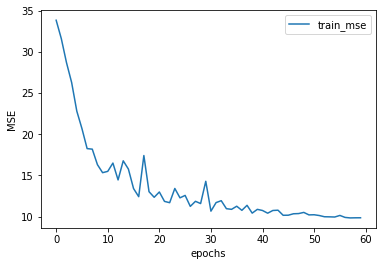

In [68]:
plt.plot(train_l, label='train_mse')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend(loc = 1)

In [70]:
#—————————————简单验证学习率最终调整结果——————————
optimizer.state_dict()

lr_lambda(60) * 0.05

# 结果是相等的

{'state': {0: {'momentum_buffer': None},
  1: {'momentum_buffer': None},
  2: {'momentum_buffer': None},
  3: {'momentum_buffer': None},
  4: {'momentum_buffer': None},
  5: {'momentum_buffer': None},
  6: {'momentum_buffer': None},
  7: {'momentum_buffer': None},
  8: {'momentum_buffer': None},
  9: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.002303489949347597,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'initial_lr': 0.05,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

0.002303489949347597

当然，我们也可以继续进行实验，对比恒定学习率时计算结果

- 对比恒定学习率为0.03时模型训练结果

In [71]:
#———————————————————恒定学习率为0.03————————————————————

# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
tanh_model1 = net_class2(act_fun= torch.tanh, in_features=5, BN_model='pre')

In [72]:
train_l3, test_l3 = fit_rec(net = tanh_model1, 
                            criterion = nn.MSELoss(), 
                            optimizer = optim.SGD(tanh_model1.parameters(), lr = 0.03), 
                            train_data = train_loader,
                            test_data = test_loader,
                            epochs = 60, 
                            cla = False, 
                            eva = mse_cal)

Text(0.5, 0, 'epochs')

Text(0, 0.5, 'MSE')

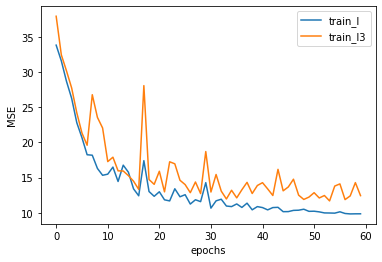

In [73]:
plt.plot(train_l, label='train_l')
plt.plot(train_l3, label='train_l3')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend(loc = 1)

#相比恒定学习为0.03的模型，加入学习率调度策略的模型，
# 模型收敛效果更好、迭代更加平稳，且收敛速度较快。

- 对比恒定学习率为0.01时模型训练结果

In [74]:
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
tanh_model1 = net_class2(act_fun= torch.tanh, in_features=5, BN_model='pre')

In [75]:
train_l1, test_l1 = fit_rec(net = tanh_model1, 
                            criterion = nn.MSELoss(), 
                            optimizer = optim.SGD(tanh_model1.parameters(), lr = 0.01), 
                            train_data = train_loader,
                            test_data = test_loader,
                            epochs = 60, 
                            cla = False, 
                            eva = mse_cal)

Text(0.5, 0, 'epochs')

Text(0, 0.5, 'MSE')

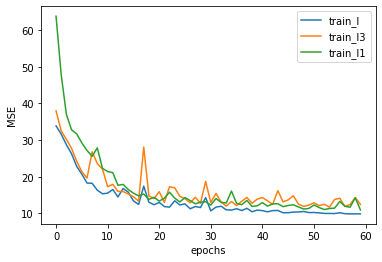

In [76]:
#——————————————————三种模型的可视化对比———————————————————
plt.plot(train_l, label='train_l')
plt.plot(train_l3, label='train_l3')
plt.plot(train_l1, label='train_l1')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend(loc = 1)

# 相比恒定学习率为0.01的模型，拥有学习率调度的模型结果更优秀。

- 对比Lesson 15.1节中学习率调度模型

In [77]:
# 设置随机数种子
torch.manual_seed(24)  

# 实例化模型  
tanh_model = net_class2(act_fun=torch.tanh, in_features=5, BN_model='pre')

In [79]:
#——————————————————分段恒定学习率模型————————————————————

# 创建用于保存记录结果的空列表容器
train_mse = []
test_mse = []

# 创建可以捕捉手动输入数据的模型训练流程
while input("Do you want to continue the iteration? [y/n]") == "y":    # 询问是否继续迭代
    epochs = int(input("Number of epochs:"))                           # 下一轮迭代遍历几次数据
    lr = float(input("Update learning rate："))                        # 设置下一轮迭代的学习率
    train_l0, test_l0 = fit_rec(net = tanh_model, 
                                criterion = nn.MSELoss(), 
                                optimizer = optim.SGD(tanh_model.parameters(), lr = lr), 
                                train_data = train_loader,
                                test_data = test_loader,
                                epochs = epochs, 
                                cla = False, 
                                eva = mse_cal)
    train_mse.extend(train_l0)
    test_mse.extend(test_l0)

    # y 30 0.03 t 30 0.01 n
# 收敛后的效果不如学习率调度器

Text(0.5, 0, 'epochs')

Text(0, 0.5, 'MSE')

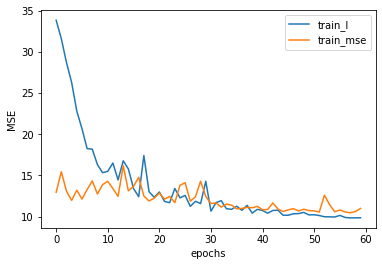

In [80]:
plt.plot(train_l, label='train_l')
plt.plot(train_mse, label='train_mse')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend(loc = 1)

很明显，由于上一节的模型是0.03学习率模型和0.01学习率模型简单叠加结果，在恒定学习率模型效果均不如本节模型的情况下，上一节课中的模型学习率调度策略也无法有更好的表现。

&emsp;&emsp;但是，令人惊讶的是，在训练了60轮之后，LambdaLR模型最终学习率在0.02附近，相比上述0.01学习率模型而言学习率更小。

但从上述的实验中我们发现，恒定学习率时从恒定0.03到恒定0.01的过程，模型准确率已经发生了明显的下降，但在如果是采用动态调整学习率的策略，则可以在一个最终更小的学习率取值的情况下取得一个更好的模型结果。

In [81]:
lr_lambda(60) * 0.05

0.002303489949347597

&emsp;&emsp;这其实说明损失函数在超平面空间的图像比一般的想象要复杂的多，很多时候并不是越靠近全域最小值点附近的通道就越窄，会导致迭代过程落入局部最小值陷阱的学习率大小取值也只是绝对概念。

正是由于损失函数的复杂性，才导致很多时候我们认为神经网络的内部训练是个“黑箱”，才进一步导致神经网络的模型训练往往以模型结果为最终依据，这也是神经网络优化算法会诞生诸多基本原理层面比较扎实，但却找不到具体能够证明优化效果的理论依据的方法。     
